In [1]:
from IPython.display import clear_output
! pip install torchmetrics
!pip install lion-pytorch
clear_output()

In [2]:
import os
import math
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.core.dtypes.cast import maybe_box_datetimelike
from copy import deepcopy
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.nn.modules.container import Sequential
from torch.utils.data import random_split, TensorDataset, Dataset, DataLoader
from torchmetrics import PearsonCorrCoef, R2Score, MeanSquaredError

import torchvision
from torchvision import datasets


from drive.MyDrive.Model_and_trainer import CustomStructureDataset, First_CNN, ProgressPlotter, BaseTrainer

import random


def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [3]:
mean = 7.4862
std = 2.1827
batch_size = 32
test_dataset = CustomStructureDataset('drive/MyDrive/Dataset/Resol_test.csv', str_dir = 'drive/MyDrive/Dataset')
test_dataset.train = False
test_dataset.normalize = True
test_dataset.mean = mean
test_dataset.std = std
test_dataset.transform = None
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size, num_workers=2)

In [4]:
model = torch.load('drive/MyDrive/Model/model_best_55_weight_mol_dyn.pt')
model = model.double()
model = model.to(device)

In [5]:
#проверка модели на тесте
trainer = BaseTrainer(
    model= model,
    train_dataloader = test_loader,

    test_dataloader= test_loader
)
y_test_pred, y_test_true = trainer.get_predictions(model=model, dl=test_loader)
pearson = PearsonCorrCoef()
corr_coef= pearson(y_test_pred, y_test_true)
mse = MeanSquaredError()
rmse = torch.sqrt(mse(y_test_pred, y_test_true))
print(f'Pearson_corr: {round(corr_coef.item(), 2)}')
print(f'RMSE: {round(rmse.item(), 3)}')

Pearson_corr: 0.6
RMSE: 1.479


In [8]:
import pandas as pd
corr_df = pd.DataFrame(columns=['Pred_pKD', 'True_pKD'])
corr_df['Pred_pKD'] = y_test_pred
corr_df['True_pKD'] = y_test_true
corr_df

,Pred_pKD,True_pKD
0,7.230985,9.16
1,6.874482,8.41
2,7.258257,5.00
3,6.468497,6.60
4,7.049604,7.48
...,...,...
123,5.872927,7.38
124,8.303429,8.49
125,7.696234,8.43
126,7.637087,9.62


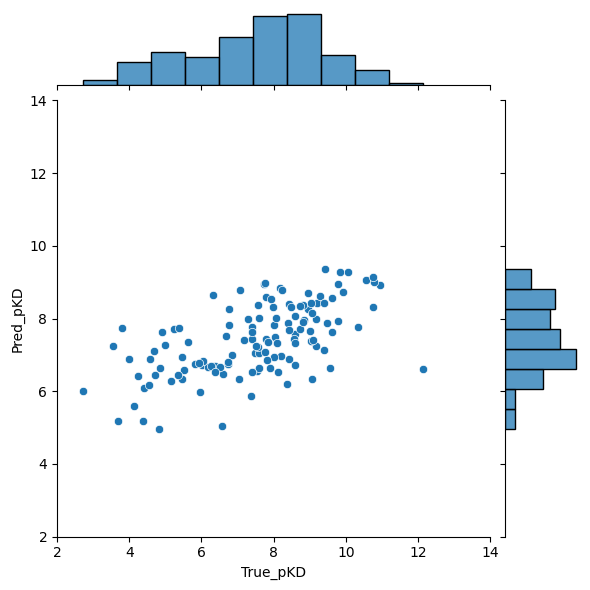

In [9]:
import seaborn as sns
sns.jointplot(data=corr_df, x='True_pKD', y='Pred_pKD', palette='Set2', ylim=(2, 14), xlim=(2, 14))

In [10]:
# 0: Акцепторы вс 1 белка + доноры 2 белка
# 1: Акцепторы вс 2 белка + доноры 1 белка
# 2: Акцепторы вс 1 белка + слабые доноры 2 белка
# 3: Акцепторы вс 2 белка + слабые доноры 1 белка
# 4: пол. заряженные атомы 1 белка + нег. заряженные атомы 2 белка
# 5: пол. заряженные атомы 2 белка + нег. заряженные атомы 1 белка
# 6: Гидрофобные атомы 1 белка + гидрофобные атомы 2 белка
# 7: Карбоксильные кислороды 1 белка + Карбоксильные кислороды 2 белка
# 8: Карбоксильные углероды 1 белка + Карбоксильные углероды 2 белка
# 9: Ароматические атомы 1 белка + ароматические атомы 2 белка
channels_names = ['HB_Ac1+Don2', 'HB_Ac2+Don1', 'HB_Ac1+Weak_Don2', 'HB_Ac2+Weak_Don1', 'Pos1+Neg2', 'Pos2+Neg1', 'Hph1+Hph2', 'Carboxy_C1+Carboxy_C2', 'Carboxy_O1+Carboxy_O2', 'Arom1+Arom2']

In [11]:
# вывод весов для каждого из каналов на входе
w0 = model.conv_stack[0].weight
w0 = pd.DataFrame(np.transpose(w0.cpu().detach().numpy(), [0, 4, 2, 3, 1]).reshape((-1, 10)),
                  columns=channels_names)

In [12]:
# расчет среднего значения для значимых нейронов
diff = (w0.abs() > 0.001).mean()
diff.sort_values(ascending=False)

Arom1+Arom2              0.954446
Carboxy_O1+Carboxy_O2    0.946064
HB_Ac2+Don1              0.945062
Carboxy_C1+Carboxy_C2    0.943422
HB_Ac1+Don2              0.938593
HB_Ac1+Weak_Don2         0.936680
HB_Ac2+Weak_Don1         0.935313
Pos1+Neg2                0.933036
Hph1+Hph2                0.928480
Pos2+Neg1                0.919005
dtype: float64

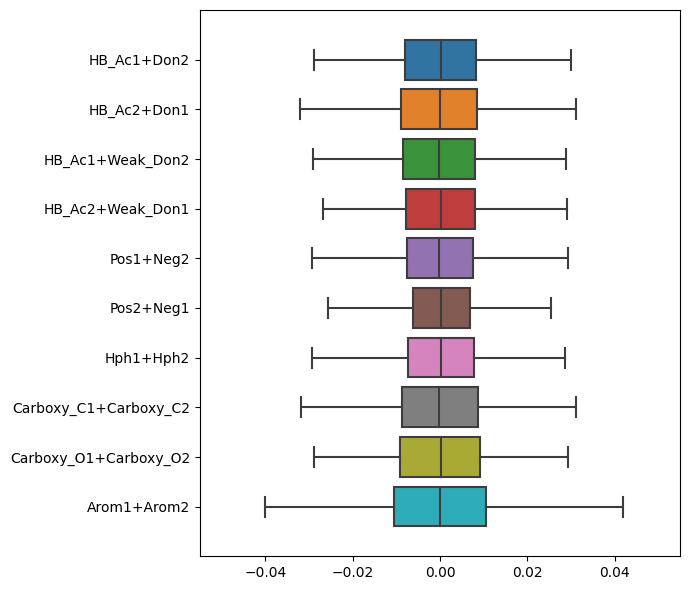

In [14]:
# range between 25th and 75th percentiles
perc_diff = ((w0.apply(lambda x: np.percentile(x, 75))
             - w0.apply(lambda x: np.percentile(x, 25)))
             .sort_values(ascending=False))

# построение разбросов весов для каждого из 10 каналов
fig, ax = plt.subplots(figsize=(7, 6))

#sns.boxplot(data=w0, fliersize=0, orient='h', order=list(perc_diff.index.values), ax=ax)
sns.boxplot(data=w0, fliersize=0, orient='h', ax=ax)
ax.set_xlim(-0.055, 0.055)
ax.set_xticks(np.arange(-0.04, 0.05, 0.02))
ax.set_ylim(10, -1)

fig.tight_layout()